## SRJ

In [ ]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity






def ags_exact(symbols, coordinates, active_electrons, active_orbitals, adapt_it, shots = None):
    print('Using active space, check if you change the H accordingly')
    H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-3g", method="pyscf",active_electrons=active_electrons, active_orbitals=active_orbitals)
    print(H)
    hf_state = qchem.hf_state(active_electrons, qubits)
    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(hf_state, active_electrons, qubits, H):
        #print('Updated hf_state is', hf_state)  
        qml.BasisState(hf_state, wires=range(qubits))
        return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
    
    # Commutator calculation for HF state
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.BasisState(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)

    #Energy calculation 
    @qml.qnode(dev)
    def ash(params, ash_excitation, hf_state, H):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]  #Appln of HF state
        for i, excitation in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.expval(H)  #Calculating the expectation value of the Hamiltonian
    
    # Calculation of New state, same as the above function but with the state return
    dev1 = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev1)
    def new_state(hf_state, ash_excitation, params):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]] #Applying the HF state
        for i, excitations in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    

    
    
    def cost(params):
        energy = ash(params, ash_excitation, hf_state, H)
        return energy

    def callback(params):
        print(f"Current parameters: {params}")
        print(f"Current cost: {cost(params)}\n")
    

    print('HF state is', circuit(hf_state, active_electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(active_electrons, qubits)
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    print('Total excitations are', len(operator_pool))
    states = [hf_state]
    params = np.zeros(len(ash_excitation), requires_grad=True) 

    null_state = np.zeros(qubits,int)
    print('Null state is', null_state)

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state
       
        for i in operator_pool:
            #print('The current excitation operator is', i)   #Current excitation operator - fermionic one
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, hf_state): # If the current state is the HF state
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        #print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value


        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation

        params = np.append(params, 0.0)  #Parameters initialization



        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = 1e-12, options = {'disp': False, 'maxiter': 1e8})

        print("Final updated parameters:", result.x)
        print("Final cost:", result.fun)

        params= (result.x)
        energies.append(result.fun)


        ostate = new_state(hf_state, ash_excitation, params)
        #print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation,params))
        gs_state = ostate
        states.append(ostate)
        
    return gs_state, params, ash_excitation, qubits, H

## So if you want the state, return the ostate and not states


import os
from time import time
import pennylane as qml
from pennylane import numpy as np
import scipy



def inite(elec,orb):
    config=[]
    list1=[]
    #singles
    for x in range(elec):
        count=orb-elec
        while (count<orb):
            for e in range(elec):
                if x==e:
                    if x%2==0:
                        config.append(count)
                        count=count+2
                    else:
                        config.append(count+1)
                        count=count+2
                else:
                    config.append(e)
                
            list1.append(config)
            config=[]
    #doubles
    for x in range(elec):
        for y in range(x+1,elec):
            count1=orb-elec
            count2=orb-elec
            for count1 in range(elec, orb, 2):
                for count2 in range(elec, orb, 2):
                    cont=0
                    if count1==count2:
                        if (x%2)!=(y%2):
                            cont=1
                    else:
                        cont=1
                    if (x%2)==(y%2) and count2<count1:
                        cont=0
                    if cont==1:    
                        for e in range(elec):
                            if x==e:
                                if x%2==0:
                                    config.append(count1)
                                else:
                                    config.append(count1+1)
                            elif y==e:
                                if y%2==0:
                                    config.append(count2)
                                else:
                                    config.append(count2+1)
                            else:
                                config.append(e)

                        list1.append(config)
                        config=[]
    return list1

def ee_exact(symbols, coordinates, active_electrons, active_orbitals ,params,ash_excitation, shots=0):

    H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-3g", method='pyscf', active_electrons=active_electrons, active_orbitals=active_orbitals)
    hf_state = qml.qchem.hf_state(active_electrons, qubits)
    print('HF state:', hf_state)
    singles, doubles = qml.qchem.excitations(active_electrons, qubits)
    wires=range(qubits)
    

    null_state = np.zeros(qubits,int)
    print('Null state is', null_state)
    list1 = inite(active_electrons,qubits)
    print('The list1 :', list1)
    values =[]
    for t in range(1):
        if shots==0:
            dev = qml.device("lightning.qubit", wires=qubits)
        else:

            dev = qml.device("lightning.qubit", wires=qubits,shots=shots)
        #circuit for diagonal part
        @qml.qnode(dev)
        def circuit_d(params, occ,wires, hf_state, ash_excitation):
            print('What is going  as hf_State:', hf_state)
            qml.BasisState(hf_state, wires=range(qubits))
            for w in occ:
                qml.X(wires=w)
            #Going to include excitations here
            for i, excitations in enumerate(ash_excitation):
                if len(ash_excitation[i]) == 4:
                    #print('Exc. zstate:', ash_excitation[i])
                    #print('Params in zstate:', params[i])
                    qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
                elif len(ash_excitation[i]) == 2:
                    #print('Single Exc. zstate:', ash_excitation[i])
                    #print('Single params in zstate:', params[i])
                    qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
            return qml.expval(H)
        #circuit for off-diagonal part
        @qml.qnode(dev)
        def circuit_od(params, occ1, occ2,wires, hf_state, ash_excitation):
            print('What is going  as hf_State:', hf_state)
            qml.BasisState(hf_state, wires=range(qubits))
            for w in occ1:
                qml.X(wires=w)
            first=-1
            for v in occ2:
                if v not in occ1:
                    if first==-1:
                        first=v
                        qml.Hadamard(wires=v)
                    else:
                        qml.CNOT(wires=[first,v])
            for v in occ1:
                if v not in occ2:
                    if first==-1:
                        first=v
                        qml.Hadamard(wires=v)
                    else:
                        qml.CNOT(wires=[first,v])
            for i, excitations in enumerate(ash_excitation):
                if len(ash_excitation[i]) == 4:
                    #print('Exc. zstate:', ash_excitation[i])
                    #print('Params in zstate:', params[i])
                    qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
                elif len(ash_excitation[i]) == 2:
                    #print('Single Exc. zstate:', ash_excitation[i])
                    #print('Single params in zstate:', params[i])
                    qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
            return qml.expval(H)
        #final M matrix
        M = np.zeros((len(list1),len(list1)))
        for i in range(len(list1)):
            for j in range(len(list1)):
                if i == j:
                    M[i,i] = circuit_d(params, list1[i], wires, null_state, ash_excitation)
        print("diagonal parts done")
        for i in range(len(list1)):
            for j in range(len(list1)):
                if i!=j:
                    Mtmp = circuit_od(params, list1[i],list1[j],wires, null_state, ash_excitation)
                    M[i,j]=Mtmp-M[i,i]/2.0-M[j,j]/2.0
        print("off diagonal terms done")
        #ERROR:not subtracting the gs energy
        eig,evec=np.linalg.eig(M)
        values.append(np.sort(eig))
    return values

symbols  = [ 'N', 'H', 'H', 'H']
print('NH3-2.70A-GS')
r_bohr = 1.8897259886 
coordinates = np.array([[0.0,0.0, 0.0], [0.0, 0.0, 1.40*r_bohr], [0.0,2.70*r_bohr,-0.336000*r_bohr],[2.70*r_bohr, 0.0, -0.336000*r_bohr]])



electrons = 10  # 7 from N and 3 from H
orbitals = 20
charge = 0

active_electrons = 6
active_orbitals = 6


gs_state, params, ash_excitation, qubits, H = ags_exact(symbols, coordinates, active_electrons, active_orbitals, shots = None, adapt_it=25) #1 is used for params



print('The params after GS is',params)
print('Ash excitation after gs state:', ash_excitation)



eig = ee_exact(symbols, coordinates, active_orbitals,active_orbitals,params, ash_excitation)
print('exact eigenvalues:\n', eig)



NH3-2.70A-GS
Using active space, check if you change the H accordingly
-53.75152326923282 * I([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]) + 0.10657306659433789 * Z(0) + 0.0009694600781622619 * (Y(0) @ Z(1) @ Y(2)) + 0.0009694600781622619 * (X(0) @ Z(1) @ X(2)) + 0.0024700350564746715 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + 0.0024700350564746715 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + 0.010807498763600086 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Y(10)) + 0.010807498763600086 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ X(10)) + 0.05164903644351726 * Z(2) + 0.0858137627937727 * (Z(0) @ Z(2)) + 0.0014327894571321137 * (Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + 0.0014327894571321137 * (X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + -0.04087440841676449 * (Z(0) @ Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + -0.04087440841676449 * (Z(0) @ X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + -0.0022838396944072237 * (Y(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(

/Users/s.poyyapakkam/miniconda3/envs/ashsri/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Highest gradient excitation is [4, 5, 8, 9]
Current parameters: [1.32954341]
Current cost: -54.79961016550585

Current parameters: [1.32954328]
Current cost: -54.799610165505875

Final updated parameters: [1.32954328]
Final cost: -54.799610165505875
The adapt iteration now is 1
Highest gradient excitation is [2, 3, 6, 7]
Current parameters: [1.32954328 1.34434116]
Current cost: -54.96285003441743

Current parameters: [1.34437188 1.34462105]
Current cost: -54.962873436164

Current parameters: [1.34437705 1.34462115]
Current cost: -54.96287343616675

Final updated parameters: [1.34437705 1.34462115]
Final cost: -54.96287343616675
The adapt iteration now is 2
Highest gradient excitation is [0, 1, 10, 11]
Current parameters: [1.34437705 1.34462115 0.4197827 ]
Current cost: -55.0028320264864

Current parameters: [1.34446493 1.34470168 0.41978301]
Current cost: -55.002832027969134

Current parameters: [1.34446493 1.34470168 0.41978301]
Current cost: -55.00283202796914

Final updated paramete

In [7]:
FCI27 = -55.18268984
-55.17563126400439 - FCI27

#-55.23160748761787  - FCI27

energy27 = np.array([-55.17563126400439, -55.17722662, -55.16383879, -55.15642263, -55.06518785,
        -55.01799022, -54.97650619, -54.97505461, -54.95945396,
        -54.95297672, -54.93600438, -54.93419903, -54.92995495,
        -54.92491331, -54.92267517, -54.91769702, -54.89041103,
        -54.8561143 , -54.8491878 , -54.83753491, -54.82396977,
        -54.82387185, -54.81509293, -54.81225945, -54.80771553,
        -54.80731992, -54.80420293, -54.76862498, -54.76679709,
        -54.74172727, -54.73832532, -54.73496366, -54.731886  ,
        -54.68270323, -54.68231781, -54.64036743, -54.6396543 ,
        -54.62770291, -54.62269603, -54.62143856, -54.62061792,
        -54.61318086, -54.61178936, -54.60489506, -54.60353663,
        -54.60352122, -54.60270836, -54.6016704 , -54.60007462,
        -54.59715064, -54.59398885, -54.58937294, -54.58386359,
        -54.58061336, -54.56806203, -54.56295739, -54.54966807,
        -54.53184336, -54.53072142, -54.52828315, -54.52134959,
        -54.51748952, -54.51161865, -54.46906153, -54.465011  ,
        -54.46357827, -54.46071912, -54.45884959, -54.43296272,
        -54.43183916, -54.41564265, -54.41510274, -54.41233794,
        -54.41150514, -54.40584548, -54.40426046, -54.40148366,
        -54.4014377 , -54.37854131, -54.37778447, -54.37282126,
        -54.37162746, -54.35342834, -54.35109573, -54.34411594,
        -54.31815918, -54.3147031 , -54.30253028, -54.2819626 ,
        -54.28165104, -54.2668281 , -54.26658738, -54.2544738 ,
        -54.24051736, -54.23660662, -54.20879104, -54.20720329,
        -54.17803763, -54.17775484, -54.16005475, -54.15860713,
        -54.15307277, -54.15270992, -54.09903549, -54.09516462,
        -54.07924391, -54.07645187, -54.07053731, -54.06563326,
        -54.04376061, -54.03778331, -54.02304084, -54.01190259,
        -53.99995832, -53.94906092, -53.92983509, -53.92807537,
        -53.90680672])

In [6]:
fenergies27 = np.array([-55.18268984, -55.18134718, -55.18018333, -55.17891976,
       -55.0946793 , -55.09467445, -55.09463012, -55.09455364,
       -55.01643264, -55.01642893, -54.99348834, -54.992532  ,
       -54.99208818, -54.99113948, -54.98001544, -54.97998688,
       -54.97917734, -54.97915185, -54.97764684, -54.97764349,
       -54.97679151, -54.97679114, -54.93314777, -54.93314091,
       -54.93313205, -54.9331082 , -54.87548764, -54.8752485 ,
       -54.87474146, -54.87408956, -54.87259981, -54.87259112,
       -54.87222722, -54.87219494, -54.87016901, -54.87010602,
       -54.86972824, -54.86971064, -54.85292738, -54.85290201,
       -54.85253357, -54.85236287, -54.85212927, -54.8519632 ,
       -54.85183251, -54.85173011, -54.83128269, -54.83128094,
       -54.83126416, -54.83125219, -54.81945546, -54.81944483,
       -54.77109155, -54.77066367, -54.77022777, -54.76979617,
       -54.64581151, -54.64386628, -54.6403458 , -54.64017901,
       -54.64002279, -54.63742961, -54.63653446, -54.63530092,
       -54.62904681, -54.62894763, -54.6276118 , -54.62698246,
       -54.62613714, -54.62478418, -54.62008606, -54.61945745,
       -54.61844272, -54.61842239, -54.61538322, -54.61523645,
       -54.57622602, -54.57394467, -54.57158564, -54.5693946 ,
       -54.55816854, -54.55816019, -54.54448655, -54.5440166 ,
       -54.54325803, -54.53979618, -54.53695973, -54.53550714,
       -54.53523587, -54.5346614 , -54.53297186, -54.53221747,
       -54.53050972, -54.52869696, -54.52805307, -54.52743715,
       -54.52052879, -54.52049937, -54.51883178, -54.51661492,
       -54.51426468, -54.51392564, -54.51383582, -54.51334899,
       -54.50655059, -54.50651423, -54.50580157, -54.50407762,
       -54.48729191, -54.48728077, -54.48686474, -54.48678826,
       -54.45754862, -54.45650609, -54.45555126, -54.45518835,
       -54.45338636, -54.45334976])

ccsd_27_27n = np.array([-55.23160748761787, -55.32191509 ,-55.19946334,-55.1568099,  -55.07867892 ,
 -55.07736858 , -55.04701701 , -55.02858986,
 -54.98956129])

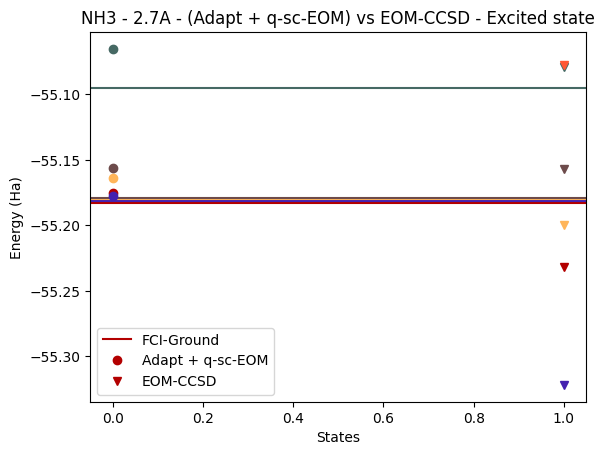

In [13]:
import matplotlib.pyplot as plt





plt.axhline(y=fenergies27[0], color="#b30000", linestyle='-', label='FCI-Ground')
plt.axhline(y=fenergies27[1], color="#4421af", linestyle='-')
plt.axhline(y=fenergies27[2], color="#ffb55a", linestyle='-')
plt.axhline(y=fenergies27[3], color="#6d4b4b", linestyle='-')
plt.axhline(y=fenergies27[4], color="#466964", linestyle='-')
#plt.axhline(y=fenergies27[5], color="#FF5733", linestyle='-')
#plt.axhline(y=fenergies27[6], color="#40E0D0", linestyle='-')

plt.plot(0,energy27[0],'o', color = '#b30000', label = 'Adapt + q-sc-EOM') 
plt.plot(0,energy27[1], 'o', color = '#4421af')
plt.plot(0,energy27[2], 'o', color = '#ffb55a')
plt.plot(0,energy27[3], 'o', color = '#6d4b4b')
plt.plot(0,energy27[4], 'o', color = '#466964')
#plt.plot(0,energy27[5], 'o', color = '#FF5733')
#plt.plot(0,energy27[6], 'o', color = '#40E0D0')

plt.plot(1, ccsd_27_27n[0],'v', color = '#b30000', label = 'EOM-CCSD') 
plt.plot(1, ccsd_27_27n[1], 'v', color = '#4421af')
plt.plot(1, ccsd_27_27n[2], 'v', color = '#ffb55a')
plt.plot(1, ccsd_27_27n[3], 'v', color = '#6d4b4b')
plt.plot(1, ccsd_27_27n[4], 'v', color = '#466964')
plt.plot(1, ccsd_27_27n[5], 'v', color = '#FF5733')
#plt.plot(1, ccsd_27_27n[5], 'v', color = '#40E0D0')

plt.legend()
#plt.ylim(-55.20, -55.10)
plt.xlabel('States')
plt.ylabel('Energy (Ha)')
plt.title('NH3 - 2.7A - (Adapt + q-sc-EOM) vs EOM-CCSD - Excited state')

plt.show()